# Laboratorio 4

#### Sebastian Aristondo 20880
#### Daniel Gonzalez 20293

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Limpieza y preprocesamiento

El dataset tiene los datos crudos, por lo que debemos de limpiarlos y preprocesarlos para poder trabajar con ellos. Para esto, se utilizo la libreria pandas para poder leer el archivo csv y poder trabajar con el. Luego utilizaremos varias funciones de nltk para poder limpiar los datos y dejarlos listos para poder trabajar con ellos.

In [107]:
data = pd.read_csv('train.csv')

In [108]:
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', text)

In [109]:
data['text'] = data['text'].apply(remove_urls)

In [110]:
data['text'] = data['text'].str.replace('[^a-zA-Z]', ' ', regex=True)
data['text'] = data['text'].apply(lambda x: x.lower())

Se realizaron tres acciones iniciales para limpiar y preprocesar datos. Primero se eliminó cualquier URL de los datos usando una expresión regular. También se mantuvieron solamente los caracteres que estuvieran de la a a la z, mayúsculas o minúsculas. Esto quiere decir que se quitó cualquier caracter como "#" o "@" y signos de puntuación. Por otra parte, se pasaron todas las palabras a minúsculas.

In [111]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))  
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_sentence = ' '.join(filtered_words)
    return new_sentence

data['text_clean'] = data['text'].apply(remove_stop_words)


Para que nuestro modelo tenga un mejor desempeño, quitaremos las palabras que no aportan información al modelo. Estas palabras se conocen como "stopwords". Para esto, usaremos la librería nltk. Esta librería tiene una lista de stopwords en inglés que usaremos para quitar las palabras que no aportan información.

In [112]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

data['text_lemmatized'] = data['text_clean'].apply(lambda x: lemmatize_words(x.split()))

El modelo no puede diferenciar entre correr, corriendo, correrá, etc. Para esto, usaremos un proceso llamado lemmatization. Este proceso consiste en convertir las palabras a su forma base. Por ejemplo, correr, corriendo, correrá, etc. se convertirán a correr. Esto nos ayudará a que el modelo pueda diferenciar entre palabras que tienen el mismo significado pero que están escritas de manera diferente.

## 2. Análisis exploratorio

In [113]:
data.head()

,id,keyword,location,text,target,text_clean,text_lemmatized
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,deeds reason earthquake may allah forgive us,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,residents asked shelter place notified officer...,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,people receive wildfires evacuation or...,1,people receive wildfires evacuation orders cal...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


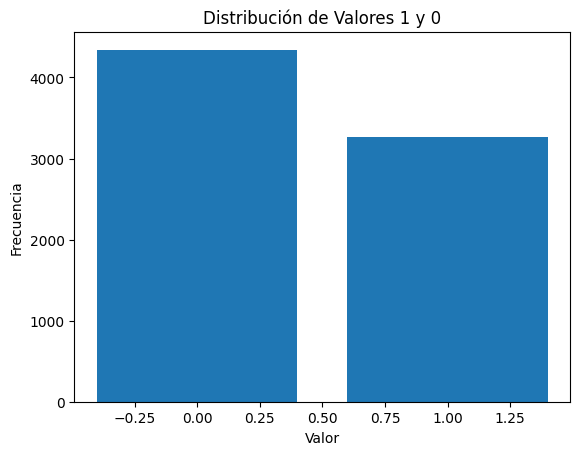

In [114]:
# Calcular la frecuencia de valores
value_counts = data['target'].value_counts()

# Crear el gráfico de barras
plt.bar(value_counts.index, value_counts.values)

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores 1 y 0')

# Mostrar el gráfico
plt.show()

Se puede observar que la cantidad de tweets de desastres y los que no son está relativamente balanceada. Hay una mayor cantidad de tweets que no son de desastres, pero no es una diferencia muy grande.

In [115]:
palabras_comunes = {0: None, 1: None}

# Iterar a través de las etiquetas únicas
for etiqueta in data['target'].unique():
    # Filtrar el DataFrame por la etiqueta actual
    df_filtrado = data[data['target'] == etiqueta]
    
    # Unir todas las listas de palabras en una sola lista
    todas_las_palabras = [palabra for lista_palabras in df_filtrado['text_lemmatized'] for palabra in lista_palabras]
    
    # Contar la frecuencia de cada palabra
    contador = Counter(todas_las_palabras)
    
    # Obtener la palabra más común
    palabra_mas_comun = contador.most_common(1)[0][0]
    
    # Almacenar la palabra más común en el diccionario
    palabras_comunes[etiqueta] = palabra_mas_comun

# Imprimir las palabras más comunes por etiqueta
print("Palabra más común para etiqueta 0:", palabras_comunes[0])
print("Palabra más común para etiqueta 1:", palabras_comunes[1])


Palabra más común para etiqueta 0: like
Palabra más común para etiqueta 1: fire


Como podemos ver el dataset en la etiqueta 1 (si es un desastre) la palabra que más se repite es fire, mientas que los tweets que no son desastres la palabra que más se repite es like. Esto nos da una idea de que palabras son las que más se repiten en cada etiqueta. Es importante destacar que esto no sería posible si no se hubiesen quitado las stopwords y si no se hubiese hecho lemmatization.

Wordcloud para Etiqueta 0:


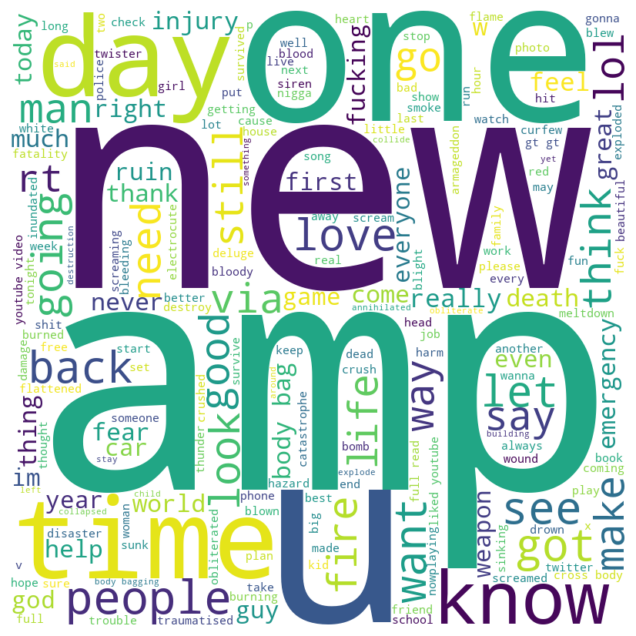

Wordcloud para Etiqueta 1:


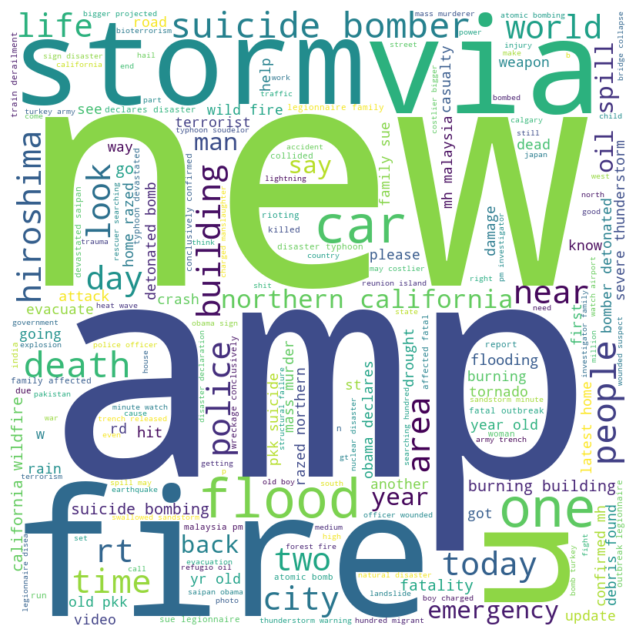

In [119]:
def process_text(text_list):
    return ' '.join(text_list)

data_clouds = data.copy()
data_clouds['processed_text'] = data_clouds['text_lemmatized'].apply(process_text)

# Separar los datos según la etiqueta
data_label_0 = data_clouds[data_clouds['target'] == 0]
data_label_1 = data_clouds[data_clouds['target'] == 1]

# Paso 2: Creación de Wordclouds
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

text_label_0 = ' '.join(data_label_0['processed_text'])
text_label_1 = ' '.join(data_label_1['processed_text'])

# Generar wordclouds para cada etiqueta
print("Wordcloud para Etiqueta 0:")
generate_wordcloud(text_label_0)

print("Wordcloud para Etiqueta 1:")
generate_wordcloud(text_label_1)

De las nubes de palabras se puede observar que la nube de palabras de desastres tiene varias palabras asociadas a ellos. Por ejemplo "emergency" o "police" o "fire" tienen bastante incidencia. Por otra parte, la nube de palabras de los tweets que no son de desastres tienen palabras como "like" o "get" o "one", palabras que no tienen mucha relación con desastres.

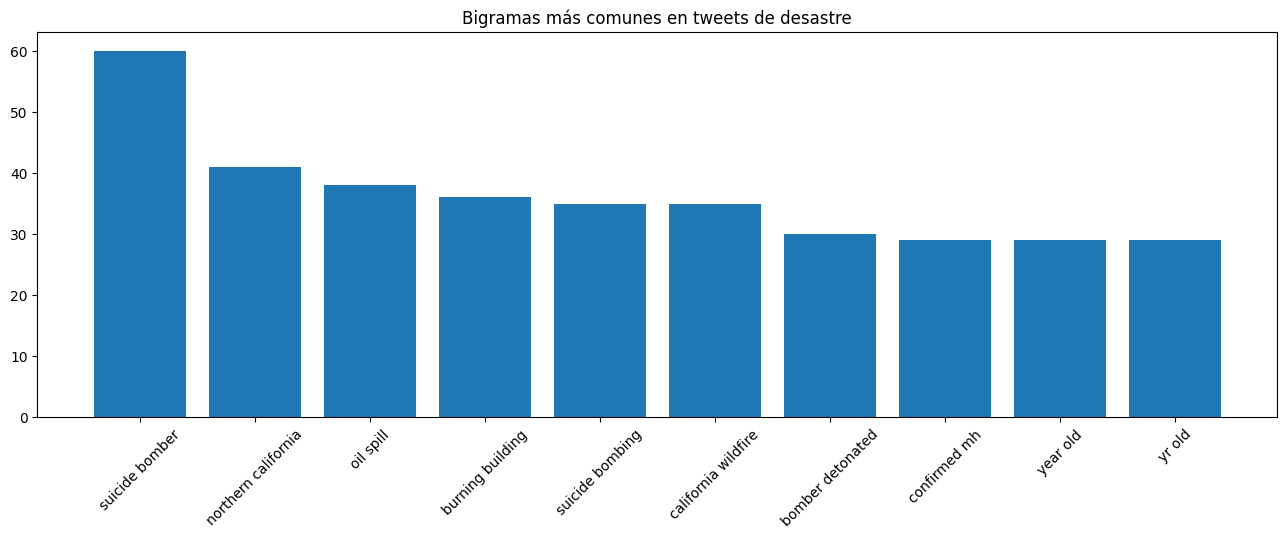

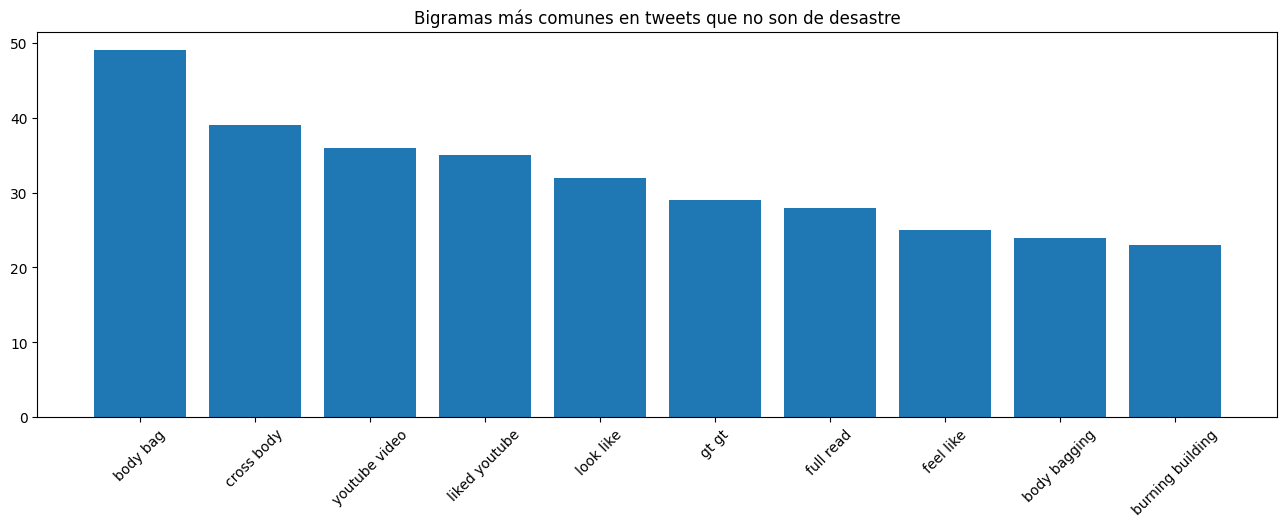

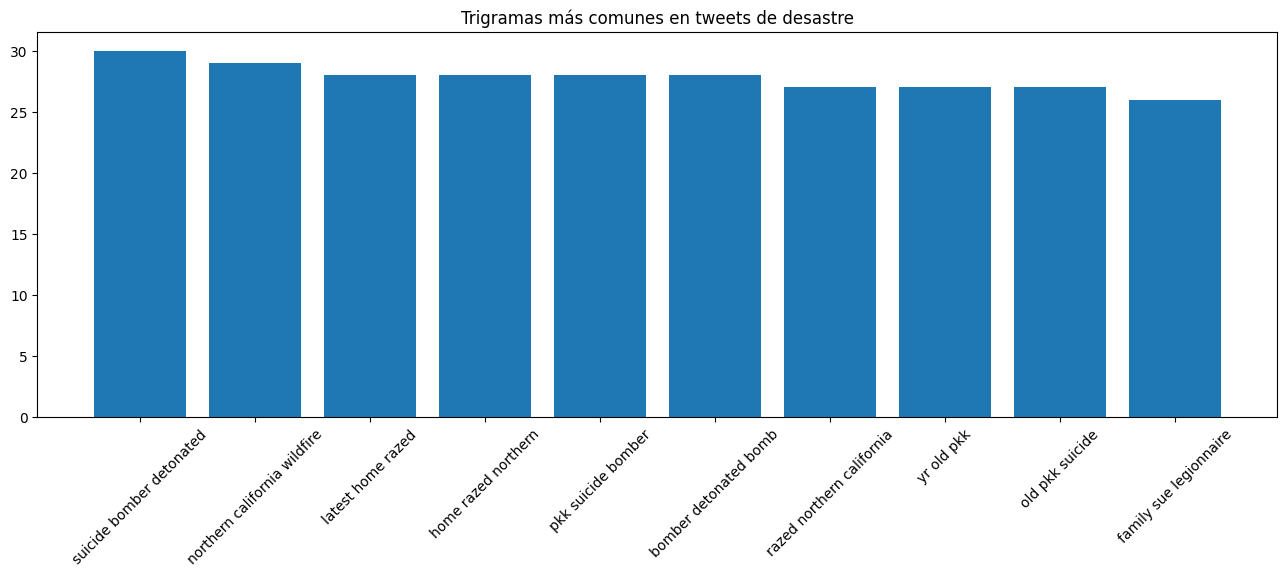

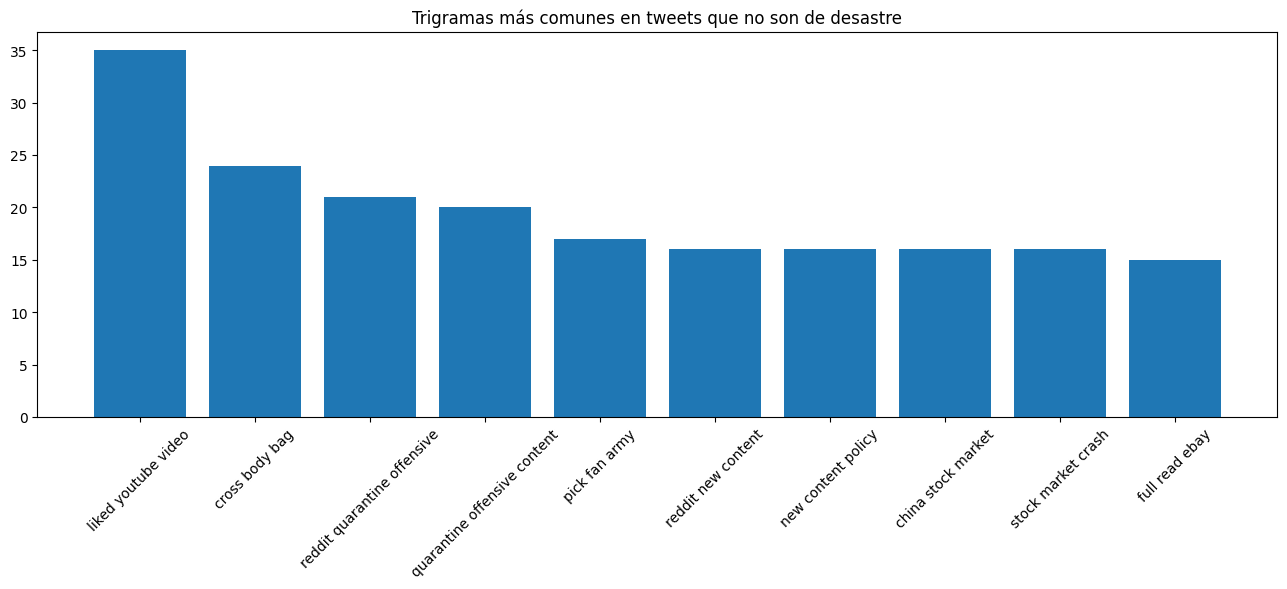

In [134]:
from nltk.util import bigrams, trigrams
from nltk.probability import FreqDist
disaster_tokens = [word for word_list in data[data['target'] == 1]['text_lemmatized'] for word in word_list]
non_disaster_tokens = [word for word_list in data[data['target'] == 0]['text_lemmatized'] for word in word_list]



disaster_bigrams = list(bigrams(disaster_tokens))
disaster_trigrams = list(trigrams(disaster_tokens))

non_disaster_bigrams = list(bigrams(non_disaster_tokens))
non_disaster_trigrams = list(trigrams(non_disaster_tokens))

disaster_bigram_freq = FreqDist(disaster_bigrams)
non_disaster_bigram_freq = FreqDist(non_disaster_bigrams)

disaster_trigram_freq = FreqDist(disaster_trigrams)
non_disaster_trigram_freq = FreqDist(non_disaster_trigrams)


def plot_most_common_bigrams(freq_dist, title):
    bigrams, frequencies = zip(*freq_dist.most_common(10))
    bigrams_str = [' '.join(bigram) for bigram in bigrams]  # Convertir bigramas a cadenas para la visualización
    plt.figure(figsize=(16, 5))
    plt.bar(bigrams_str, frequencies)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_most_common_bigrams(disaster_bigram_freq, 'Bigramas más comunes en tweets de desastre')
plot_most_common_bigrams(non_disaster_bigram_freq, 'Bigramas más comunes en tweets que no son de desastre')
plot_most_common_bigrams(disaster_trigram_freq, 'Trigramas más comunes en tweets de desastre')
plot_most_common_bigrams(non_disaster_trigram_freq, 'Trigramas más comunes en tweets que no son de desastre')

Como podemos ver en los bigramas o trigramas para los desastres lo más común habla respecto a incedios, bombardero suicida, gente de avanzada edad y derrame de aciete

Mientras que los que no son desastre hablan de gustos


### Modelo NLP


In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data['text_lemmatized'].apply(process_text), data['target'], test_size=0.3, random_state=42)

# Vectorizar los tweets usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entrenar un modelo de Regresión Logística
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Evaluar la precisión del modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, clf.predict(X_test_tfidf))
print(f"El modelo obtuvo una precisión de: {accuracy}")

El modelo obtuvo una precisión de: 0.8095446584938704


Tras toda la limpieza obtuvimos un modelo con un precisión de 0.81 lo cual es un resultado bastante bueno para un modelo que debe procesar y analizar lenguaje natural.

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Puedes ajustar el número de características
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [150]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vec, y_train)

MultinomialNB()

In [151]:
y_pred = naive_bayes_classifier.predict(X_test_vec)

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.8051663747810858
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84      1318
           1       0.82      0.69      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284



Se puede observar que la accuracy del modelo es moderadamente buena, con 0.8. El modelo predice correctamente el tipo de tweet la mayoría del tiempo.

In [152]:
def predict(tweet):
    tweet = remove_urls(tweet)
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = tweet.lower()
    tweet = remove_stop_words(tweet)
    tweet = lemmatize_words(tweet.split())
    tweet = process_text(tweet)
    tweet_vec = vectorizer.transform([tweet])
    return naive_bayes_classifier.predict(tweet_vec)[0]

In [154]:
tweet = input("Ingrese un tweet> ")
prediction = predict(tweet)
print("El tweet es de un desastre" if prediction == 1 else "El tweet no es de un desastre")

El tweet no es de un desastre
